In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from torch.utils.data import DataLoader, Dataset
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from scipy import integrate

import scienceplots
plt.style.use(['science'])

# font sizes
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 16})

In [2]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }

    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]  
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }

In [3]:
def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if calculated_deltas is torch.Tensor else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [4]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']


dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})


# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

In [6]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

# load the model
try:
    tpp_model.load_state_dict(torch.load('models/tpp_model.pt'))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

Model loaded successfully, skipping training.


/tmp/ipykernel_2066971/2944073584.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tpp_model.load_state_dict(torch.load('models/tpp_model.pt'))


In [7]:
batch = next(iter(test_loader))

In [11]:
batch['time_delta_seqs'].shape

torch.Size([32, 38])

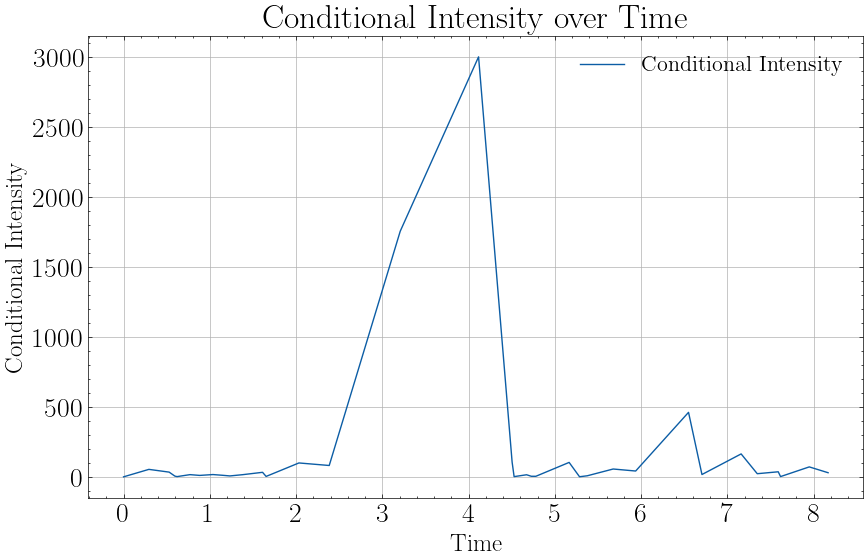

In [21]:
base_intensity = tpp_model.decoder.intensity_b

# get mask for the batch according to the sequence length
mask = torch.arange(batch['time_seqs'].shape[1]).expand(len(batch['time_seqs']), batch['time_seqs'].shape[1]) < batch['sequence_length'].unsqueeze(1)

# get one batch from the test loader
batch = next(iter(test_loader))

# get one time_delta_seq from the batch
time_delta_seq = batch['time_delta_seqs'][0].to(device)

cond_intensity = tpp_model.criterion.compute_intensity_integral(base_intensity, time_delta_seq)
time_seqs = batch['time_seqs'][0].to(device)

# mask the time sequences
time_seqs = time_seqs[mask[0]]
cond_intensity = cond_intensity[mask[0]]

# plot the intensity function
plt.figure(figsize=(10, 6))
plt.plot(time_seqs.detach().cpu().numpy(), cond_intensity.detach().cpu().numpy(), label='Conditional Intensity')
plt.xlabel('Time')
plt.ylabel('Conditional Intensity')
plt.title('Conditional Intensity over Time')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# load vaetpp model
HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# calculate the number of steps for beta annealing and warmup
num_epochs = 200
num_steps = len(train_loader) * num_epochs
cyclic_steps = num_steps // 5
warmup_steps = len(train_loader) * 20

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device, beta_steps=num_steps, warmup_steps=warmup_steps, beta_start=0, beta_end=0.5, l1_lambda=0.000, l2_lambda=0.000).to(device)

# load
try:
    vae_model.load_state_dict(torch.load('models/vae_model.pt'))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

Model loaded successfully, skipping training.


/tmp/ipykernel_2066971/3841778593.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('models/vae_model.pt'))


Latent samples shape: (100, 32)


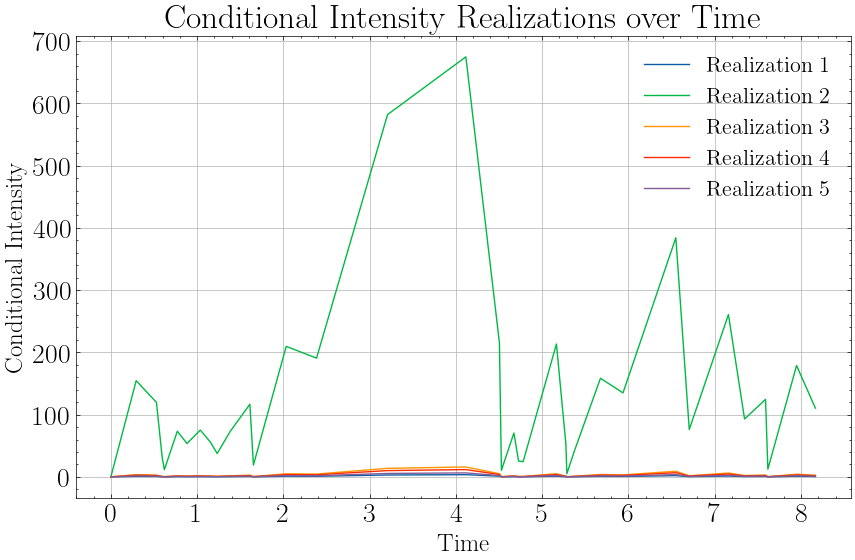

In [ ]:
def sample_vae_latent_space(model, data_loader, device, num_samples=100, use_posterior=True):
    """
    Sample from the VAE latent space for temporal point processes.
    
    Args:
        model: The VAE model
        data_loader: DataLoader containing the input data
        device: Device to run the model on
        num_samples: Number of samples to generate
        use_posterior: If True, sample from posterior distribution. If False, sample from prior.
    
    Returns:
        numpy.ndarray: Sampled points from the latent space
    """
    model.eval()
    
    if use_posterior:
        # Get a batch of data
        batch = next(iter(data_loader))
        batch = {k: v.to(device) for k, v in batch.items()}
        sequence_lengths = batch["sequence_length"].to(device)
        
        # Identify the padding tokens
        mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
        mask = mask.cpu().numpy()
        
        with torch.no_grad():
            output = model(batch)
            mu = output.mu.cpu().numpy()
            logvar = output.logvar.cpu().numpy()
            
            mu = mu[mask].reshape(-1, mu.shape[-1])
            logvar = logvar[mask].reshape(-1, logvar.shape[-1])
            
            if len(mu) > num_samples:
                idx = np.random.choice(len(mu), num_samples, replace=False)
                mu = mu[idx]
                logvar = logvar[idx]
        
        # Sample from the posterior N(μ, σ²)
        std = np.exp(0.5 * logvar)
        samples = mu + np.random.randn(*mu.shape) * std
        
    else:
        # Sample from the prior N(0, I)
        latent_dim = model.latent_dim  # Assuming your model has this attribute
        samples = np.random.randn(num_samples, latent_dim)
    
    return samples


def compute_additional_realizations(vae_model, data_loader, device, num_realizations=5):
    vae_model.eval()
    
    latent_samples = sample_vae_latent_space(vae_model, data_loader, device)
    
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # Identify the padding tokens
    mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
    
    with torch.no_grad():
        base_intensity = vae_model.decoder.intensity_b
        time_delta_seqs = batch['time_delta_seqs']
        time_seqs = batch['time_seqs']
        
        time_delta_seq = time_delta_seqs[0]
        time_seq = time_seqs[0]
        seq_mask = mask[0]
        
        cond_intensity_realizations = []
        
        print("Latent samples shape:", latent_samples.shape)
        
        for latent_sample in latent_samples[:num_realizations]:
            # print("Latent sample shape:", latent_sample.shape)
            
            # Add batch dimension
            latent_sample_tensor = torch.tensor(latent_sample, device=device, dtype=torch.float32).unsqueeze(0)
            # print("Input to decoder shape:", latent_sample_tensor.shape)
            
            time_logits, mark_logits = vae_model.decoder.decode(latent_sample_tensor)
            
            cond_intensity = vae_model.criterion.compute_intensity_integral(time_logits, time_delta_seq).squeeze()
            
            # Mask the time sequences
            time_seq_masked = time_seq[seq_mask]
            
            # print("Shape of time_seq_masked:", time_seq_masked.shape)
            # print("Shape of cond_intensity:", cond_intensity.shape)
            # print("Shape of seq_mask:", seq_mask.shape)
            
            cond_intensity_masked = cond_intensity[seq_mask]
            
            cond_intensity_realizations.append(cond_intensity_masked.detach().cpu().numpy())
        
        # Plot the intensity function realizations
        plt.figure(figsize=(10, 6))
        for i, cond_intensity in enumerate(cond_intensity_realizations):
            plt.plot(time_seq_masked.detach().cpu().numpy(), cond_intensity, label=f'Realization {i+1}')
        
        plt.xlabel('Time')
        plt.ylabel('Conditional Intensity')
        plt.title('Conditional Intensity Realizations over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to compute and visualize additional realizations of the conditional intensity
compute_additional_realizations(vae_model, test_loader, device)


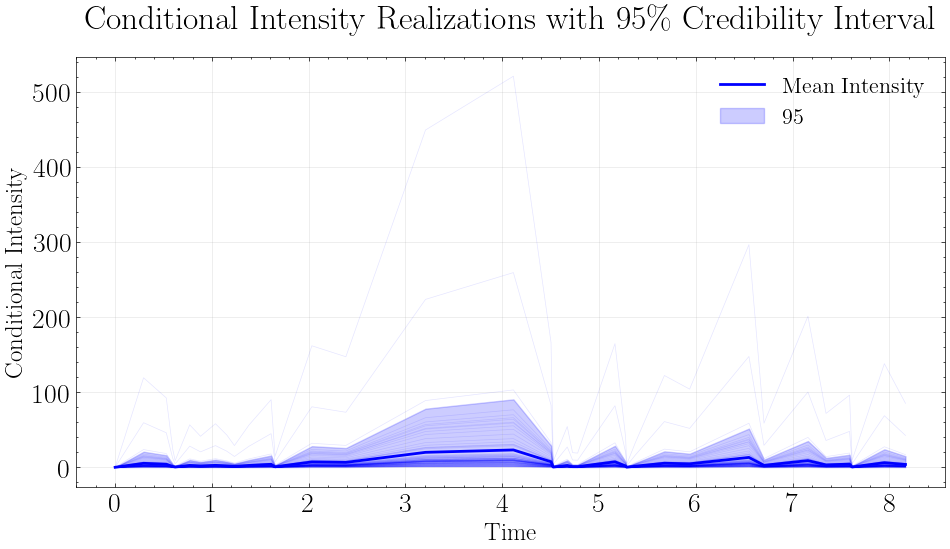

In [54]:
def compute_additional_realizations(vae_model, data_loader, device, num_realizations=50):
    """
    Compute and visualize multiple realizations of the conditional intensity function
    with credibility intervals.
    """
    vae_model.eval()
    
    latent_samples = sample_vae_latent_space(vae_model, data_loader, device)
    
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # Identify the padding tokens
    mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
    
    with torch.no_grad():
        time_delta_seqs = batch['time_delta_seqs']
        time_seqs = batch['time_seqs']
        
        time_delta_seq = time_delta_seqs[0]
        time_seq = time_seqs[0]
        seq_mask = mask[0]
        
        # Store all realizations for computing statistics
        all_intensities = []
        time_seq_masked = time_seq[seq_mask]
        
        for latent_sample in latent_samples[:num_realizations]:
            latent_sample_tensor = torch.tensor(latent_sample, device=device, dtype=torch.float32).unsqueeze(0)
            time_logits, mark_logits = vae_model.decoder.decode(latent_sample_tensor)
            cond_intensity = vae_model.criterion.compute_intensity_integral(time_logits, time_delta_seq).squeeze()
            cond_intensity_masked = cond_intensity[seq_mask]
            all_intensities.append(cond_intensity_masked.detach().cpu().numpy())
        
        # Convert to numpy array for easier computation
        all_intensities = np.array(all_intensities)
        time_points = time_seq_masked.detach().cpu().numpy()
        
        # Compute statistics
        mean_intensity = np.mean(all_intensities, axis=0)
        std_intensity = np.std(all_intensities, axis=0)
        
        # Compute 95% credibility interval
        lower_ci = np.percentile(all_intensities, 2.5, axis=0)
        upper_ci = np.percentile(all_intensities, 97.5, axis=0)
        
        # Create the visualization
        plt.figure(figsize=(10, 6))
        
        # Plot individual realizations with low opacity
        for intensity in all_intensities:
            plt.plot(time_points, intensity, color='blue', alpha=0.1, linewidth=0.5)
        
        # Plot mean and credibility intervals
        plt.plot(time_points, mean_intensity, color='blue', linewidth=2, label='Mean Intensity')
        plt.fill_between(time_points, lower_ci, upper_ci, color='blue', alpha=0.2, 
                        label='95% Credibility Interval')
        
        plt.xlabel('Time')
        plt.ylabel('Conditional Intensity')
        plt.title('Conditional Intensity Realizations with 95\% Credibility Interval', pad=20)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Improve layout
        plt.tight_layout()
        return plt.gcf()
    
    
fig = compute_additional_realizations(vae_model, test_loader, device, num_realizations=100)
plt.show()